## EDA

- Wikipedia comments on toxic comments

### Import Packages

In [1]:
import pandas as pd
import numpy as np

import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
nltk.download('stopwords')
import keras
from keras.preprocessing.text import Tokenizer, text_to_word_sequence

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from google.colab import drive

from collections import Counter
import re
import string

!pip install transformers
from transformers import BartTokenizer, TFBartForConditionalGeneration
from pprint import pprint

!pip install better_profanity
from better_profanity import profanity

pd.set_option("display.max_rows", None, # display all rows
              "display.max_columns", None, # display all columns
              "display.max_colwidth", None, # expand column width
              "display.html.use_mathjax", False) # disable Latex style mathjax rendering

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 7.0 MB/s 
     |████████████████████████████████| 101 kB 2.3 MB/s 
     |████████████████████████████████| 596 kB 38.6 MB/s 
     |████████████████████████████████| 6.6 MB 38.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 46 kB 2.4 MB/s 


### Mount Drive

In [2]:
drive.mount('/drive') 
%cd "../../drive/MyDrive/W266 Project/data"
# %cd "/drive/MyDrive/W266 Project/Colab Notebooks/Exploration"
# %ls

Mounted at /drive
/drive/.shortcut-targets-by-id/1p1bDkEjmNKPzX456WZWBr8qtvPr6Pt5m/W266 Project/data


### Import Data
Data downloaded from [kaggle link](https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/overview) to drive

In [3]:
train_raw = pd.read_csv('jigsaw-toxic-comment-classification-challenge/train.csv').set_index('id')
test_raw = pd.read_csv('jigsaw-toxic-comment-classification-challenge/test.csv').set_index('id')
test_labels = pd.read_csv('jigsaw-toxic-comment-classification-challenge/test_labels.csv').set_index('id')
test_raw = test_raw.join(test_labels)

### Inspect Data



#### Missing Data

In [4]:
train_raw.isna().sum()

comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

#### Data Shape + Summary

In [5]:
print(f'TRAIN: {train_raw.shape[0]} records and {train_raw.shape[1]} features')
print(f'TEST:  {test_raw.shape[0]} records and {test_raw.shape[1]} features')

TRAIN: 159571 records and 7 features
TEST:  153164 records and 7 features


In [ ]:
train_raw.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0
000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,0,0,0,0,0
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0


In [11]:
df_count = train_raw[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].reset_index(drop=True).sum(axis = 1)

In [20]:
df_count.value_counts()

0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
dtype: int64

The test data, however, does not take on only 0 or 1 values. it takes values of -1, 0, or 1. Values of -1 indicate a comment is not used for scoring, and the label type is lost. Therefore, we will remove any data where all column values are -1. 

In [ ]:
test_raw.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,153164.000000,153164.000000,153164.000000,153164.000000,153164.000000,153164.000000
mean,-0.542530,-0.579895,-0.558193,-0.580913,-0.559916,-0.577642
std,0.572465,0.498408,0.542966,0.496195,0.539594,0.503260
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Note: Wherever a value is -1, all other column values take on -1. Which is over half of 'test'

In [ ]:
test_labels.value_counts().head()

toxic  severe_toxic  obscene  threat  insult  identity_hate
-1     -1            -1       -1      -1      -1               89186
 0      0             0        0       0       0               57735
 1      0             1        0       1       0                1932
                      0        0       0       0                1710
                      1        0       0       0                 854
dtype: int64

Reducing test_raw down to usable values

In [ ]:
test_raw = test_raw[test_raw['toxic'] >= 0].copy()

#### Correlation Matrix

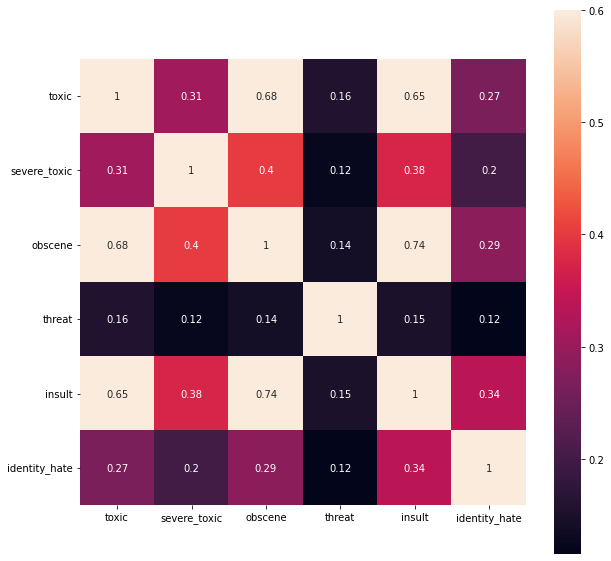

In [ ]:
plt.figure(figsize = [10, 10])
targets = list(train_raw.columns[1:])
corr_plot = train_raw[targets].corr()
sns.heatmap(corr_plot, vmax=0.6, square=True, annot=True)
plt.yticks(rotation = 360)
plt.show()

#### Comment Type Breakdown

Now that test and train have the same form, we can inspect some of the data.

First, we can see that the data is incredibly unbalanced, with the majority of cases appearing with label of 0. 

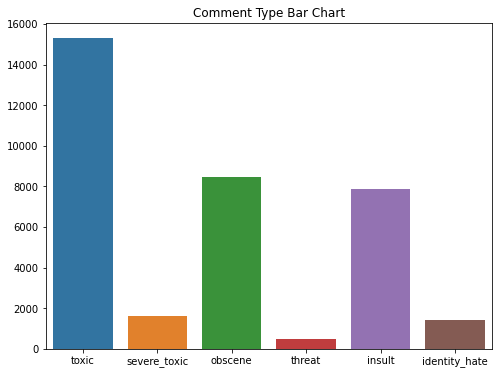

toxic  severe_toxic  obscene  threat  insult  identity_hate
0      0             0        0       0       0                143346
1      0             0        0       0       0                  5666
                     1        0       1       0                  3800
                                      0       0                  1758
                     0        0       1       0                  1215
       1             1        0       1       0                   989
       0             1        0       1       1                   618
0      0             1        0       0       0                   317
                     0        0       1       0                   301
1      1             1        0       1       1                   265
0      0             1        0       1       0                   181
1      1             1        0       0       0                   158
       0             0        0       0       1                   136
                              

In [ ]:
df = train_raw[targets].copy()
count_dict = {}
for commentType in targets:
    other = list(targets)
    count = list()
    df_selection = df[(df[commentType] == 1)]
    other.remove(commentType)
    count.append(('total', len(df_selection)))
    for i in other:
        count.append((i, df_selection[i].sum()))
    count_dict[commentType] = count

totals = [v[0][1] for k, v in count_dict.items()]
    
plt.figure(figsize=[8, 6])
plt.title('Comment Type Bar Chart')
sns.barplot(x = list(count_dict.keys()), y = totals)
plt.show()

train_raw[['toxic', 'severe_toxic', 'obscene', 
           'threat', 'insult', 'identity_hate']].value_counts()

This is partially misleading, though, as we don't expect all rows to be filled with 1's. This pseudo-one-hot-encoded structure is also not ideal for our models, so we will essentially pivot it to have one binary column, where we classify a comment as a threat (1) or non-threatening (0)

This is done with the label_violent function, and is generic enough to be used for test and train

#### Display Comments

In [ ]:
lineBreak = '-' * 100
commentBreak = '*' * 100
num = 5

for target in targets:
  print(f'\n{lineBreak}\nCategory: {target}\n{lineBreak}')
  viol = np.where(df[target]==1)[0]
  rand_Vcomments = np.random.choice(viol, num)
  for r in rand_Vcomments:
    print(train_raw.reset_index().comment_text.loc[r])
    print(commentBreak)


----------------------------------------------------------------------------------------------------
Category: toxic
----------------------------------------------------------------------------------------------------
stop murder 

You are very unfriendly and falsely accusing me.  You are not helpful but a bully.  Look at yourself.
****************************************************************************************************
SUPPRESSING THAT, YOU FASCISTS
SO FUCK YOU FOR SUPPRESSING THAT, YOU FASCISTS
SO FUCK YOU FOR SUPPRESSING THAT, YOU FASCISTS
SO FUCK YOU FOR SUPPRESSING THAT, YOU FASCISTS
SO FUCK YOU FOR SUPPRESSING THAT, YOU FASCISTS
SO FUCK YOU FOR SUPPRESSING THAT, YOU FASCISTS
SO FUCK YOU FOR SUPPRESSING THAT, YOU FASCISTS
SO FUCK YOU FOR SUPPRESSING THAT, YOU FASCISTS
SO FUCK YOU FOR SUPPRESSING THAT, YOU FASCISTS
SO FUCK YOU FOR SUPPRESSING THAT, YOU FASCISTS
SO FUCK YOU FOR SUPPRESSING THAT, YOU FASCISTS
SO FUCK YOU FOR SUPPRESSING THAT, YOU FASCISTS
SO FUCK YOU FOR 

#### Concatenate Multilabels

In [ ]:
def label_violent(df, violent_types):
    
    # Set the list of types to consider violent
    condition = ' == 1 | '.join(violent_types) + ' == 1'
    violent_inds = df.query(condition).index    # indices for violent = 1
    non_violent_inds = df.index.difference(violent_inds)    # indices for violent = 0

    # isolate violent and non-violent data
    violent = df.loc[violent_inds]
    violent['violent'] = 1
    non_violent = df.loc[non_violent_inds]
    non_violent['violent'] = 0

    # Stack violent and non-violent sub dfs
    df = pd.concat([violent, non_violent], axis = 0)
    
    # Return df with only comment text and violent = 1 or 0
    return df[['comment_text', 'violent']]

In [ ]:
violent_cats = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train = label_violent(train_raw, violent_cats)
test = label_violent(test_raw, violent_cats)

Now we can see there is a slightly lesser gap between 0 and 1

In [ ]:
train['violent'].value_counts()

0    143346
1     16225
Name: violent, dtype: int64

#### Frequent Words

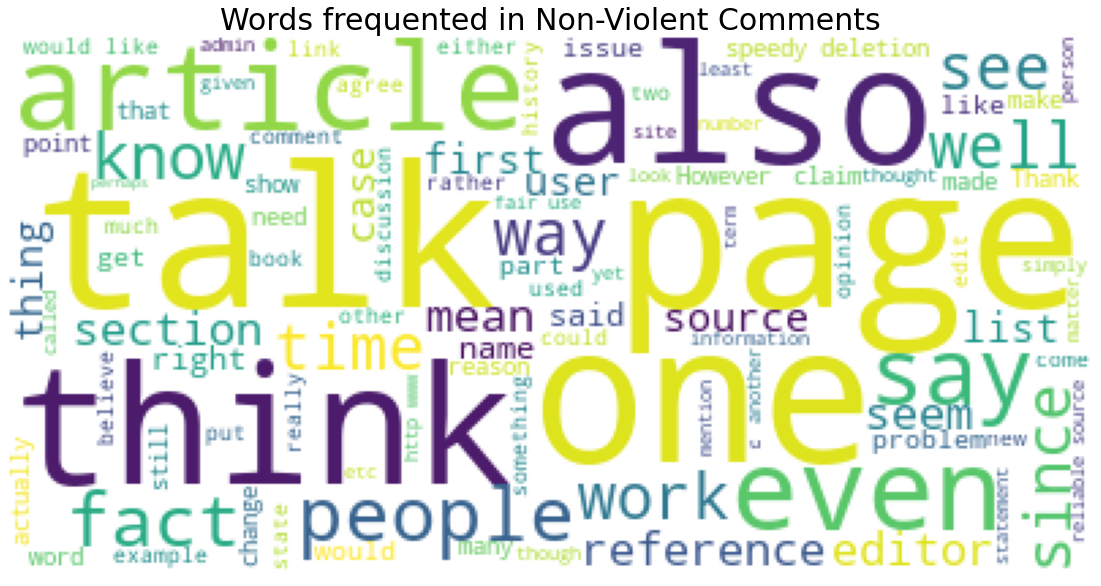

In [ ]:
# non-violent comments
subset = train[train.violent == False]
text = subset.comment_text.values
wc = WordCloud(background_color='white', max_words=100,
              stopwords=set(stopwords.words('english')))
wc.generate(' '.join(text))
plt.figure(figsize=(20,10))
plt.axis('off')
plt.title('Words frequented in Non-Violent Comments', fontsize = 30)
plt.imshow(wc.recolor(colormap = 'viridis' ,random_state = 2), alpha = 0.98)
plt.show()

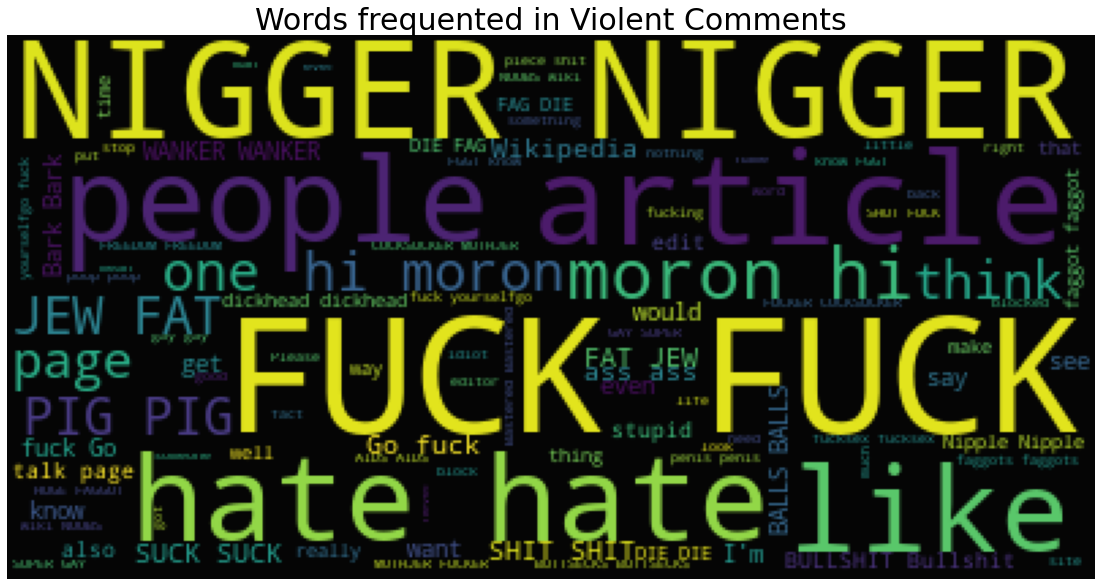

In [ ]:
# violent comments
subset = train[train.violent == True]
text = subset.comment_text.values
wc = WordCloud(background_color='black', max_words=100,
              stopwords=set(stopwords.words('english')))
wc.generate(' '.join(text))
plt.figure(figsize=(20,10))
plt.axis('off')
plt.title('Words frequented in Violent Comments', fontsize = 30)
plt.imshow(wc.recolor(colormap = 'viridis' ,random_state = 2), alpha = 0.98)
plt.show()

In [ ]:
train.to_csv('transformed/train.csv')
test.to_csv('transformed/test.csv')

### Load Data with Binary Labels

In [ ]:
train = pd.read_csv('transformed/train.csv').set_index('id')
test = pd.read_csv('transformed/test.csv').set_index('id')

In [ ]:
test.shape

(63978, 2)

In [ ]:
train_censor = pd.read_csv('transformed_censor_profanity/train_profanity_censor.csv')
test_censor = pd.read_csv('transformed_censor_profanity/test_profanity_censor.csv')

In [ ]:
test_censor.shape

(63972, 2)

In [ ]:
test.iloc[233:270]

,comment_text,violent
id,,
0a29805d107a2f51,"==You are famous (also stupid) == \n\n The visitors are coming from here a secret website run by hackers on steroids. It will be gone in a couple days, and them with it. Unfortunately, until then, they're going to vandalize every equation, and it's going to take you months to fix it all. This happened to the Stephen Colbert article, and it was a disaster. It would be good if you would learn from that. If you're smart (and honest), you'll unlock the article and let it be vandalized.",1
0a3e3cab814fdbcb,SCREW YOU HIPPIE!!! YOU ARE NOT A PERSON CAPABLE OF DESCIDING IF A SONG IS MORE IMPORTAINGT THAN ANOTHER!,1
0a5ac2e353e63260,He was a gay faggot who liked the D,1
0a63b16ee388e0a0,"On the subject of Labour at the time, see also fellow traveler and useful idiot.......",1
0a64e099b50dafd9,:Obvious sock of peepie/creampie. Wonder were he is editing from so he could avoid CU.,1
0a6f266436c60a69,WTF F YOU BASTARDS.,1
0a6fee5ea1f7b717,"== Sorry, but you are an asshole == \n\n This is very insane to delete an article like this.",1
0a9006318fd1804a,::No I am a reactionary jerk...that is why these trolls like jerking my chain so much...don't worry...I plan on making some alterations.,1
0a94c605e9ce7e05,== Nick schweikhart == \n\n Nick spends all day every day playing his stupid circle game.,1


In [ ]:
train_censor['violent'] = train['violent'].reset_index(drop=True)
test_censor['violent'] = test['violent'].reset_index(drop=True)

In [ ]:
test_censor.head()

,comment_text,violent
0,"Arabs are committing genocide in Iraq, but no protests in Europe. May Europe also burn in ****.",1
1,DJ Robinson is *** as ****! he sucks his **** so much!!!!!,1
2,"**** off, you anti semitic ****.",1
3,"How dare you vandalize that page about the HMS Beagle! Don't vandalize again, demon!",1
4,"No, he is an arrogant, self serving, immature idiot. Get it right.",1


#### Data Transformation

In [ ]:
def comment_transforms(comment_string, phase = 4):
  if phase == 1:
      comment_string = str.lower(comment_string)
      comment_string = comment_string.replace('{','')\
                                      .replace('}','')\
                                      .replace('>','')\
                                      .replace('<','')\
                                      .replace('?','.')\
                                      .replace('-',' ')\
                                      .replace('...',' ')\
                                      .replace('\n',' ')\
                                      .replace(':','')\
                                      .replace('"','')\
                                      .replace('!','')
  elif phase == 2:   
      comment_string = str.lower(comment_string)
      comment_string = comment_string.replace('{','')\
                                      .replace('}','')\
                                      .replace('>','')\
                                      .replace('<','')\
                                      .replace('?','.')\
                                      .replace('-',' ')\
                                      .replace('...',' ')\
                                      .replace('\n',' ')\
                                      .replace(':','')\
                                      .replace('"','')\
                                      .replace('[','')\
                                      .replace(']','')\
                                      .replace('*','')\
                                      .replace('\t',' ')\
                                      .replace('\\','')\
                                      .replace('\/','')\
                                      .replace('=','')\
                                      .replace('@','')\
                                      .replace('(','')\
                                      .replace(')','')\
                                      .replace('|','')\
                                
      # remove sensitive info such as IP, username
      comment_string = re.sub('\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}',' ', comment_string)
      comment_string = re.sub('\[\[.*\]','', comment_string)
      comment_string = re.sub(' +', ' ', comment_string)
      comment_string = re.sub('-+', ' ', comment_string)
      comment_string = re.sub('\.+', '.', comment_string)
      comment_string = re.sub('\^+', ' ', comment_string)
  
  elif phase == 3:  
      comment_string = comment_string.replace('{','')\
                                      .replace('}','')\
                                      .replace('>','')\
                                      .replace('<','')\
                                      .replace('-',' ')\
                                      .replace('...',' ')\
                                      .replace('\n',' ')\
                                      .replace(':','')\
                                      .replace('"','')\
                                      .replace('[','')\
                                      .replace(']','')\
                                      .replace('*','')\
                                      .replace('\t',' ')\
                                      .replace('\\','')\
                                      .replace('\/','')\
                                      .replace('=','')\
                                      .replace('@','')\
                                      .replace('(','')\
                                      .replace(')','')\
                                      .replace('|','')\
                                
      # remove sensitive info such as IP, username
      comment_string = re.sub('\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}',' ', comment_string)
      comment_string = re.sub('\[\[.*\]','', comment_string)
      comment_string = re.sub(' +', ' ', comment_string)
      comment_string = re.sub('-+', ' ', comment_string)
      comment_string = re.sub('\.+', '.', comment_string)
      comment_string = re.sub('\^+', ' ', comment_string)
    
  elif phase == 4:
      comment_string = profanity.censor(text=comment_string,censor_char='*')
      comment_string = comment_string.replace('{','')\
                                      .replace('}','')\
                                      .replace('>','')\
                                      .replace('<','')\
                                      .replace('-',' ')\
                                      .replace('...',' ')\
                                      .replace('\n',' ')\
                                      .replace(':','')\
                                      .replace('"','')\
                                      .replace('[','')\
                                      .replace(']','')\
                                      .replace('\t',' ')\
                                      .replace('\\','')\
                                      .replace('\/','')\
                                      .replace('=','')\
                                      .replace('@','')\
                                      .replace('(','')\
                                      .replace(')','')\
                                      .replace('|','')\
                                
      # remove sensitive info such as IP, username
      comment_string = re.sub('\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}',' ', comment_string)
      comment_string = re.sub('\[\[.*\]','', comment_string)
      comment_string = re.sub(' +', ' ', comment_string)
      comment_string = re.sub('-+', ' ', comment_string)
      comment_string = re.sub('\.+', '.', comment_string)
      comment_string = re.sub('\^+', ' ', comment_string)
  
  return comment_string

train['comment_text_transf'] = train['comment_text'].apply(comment_transforms)
test['comment_text_transf'] = test['comment_text'].apply(comment_transforms)

In [ ]:
train['comment_text_transf'][0]
# profanity.censor(train['comment_text'][0])


In [ ]:
# print(dir(profanity))
profanity.load_censor_words()#('Fuck')

#### Display Transformed Comments

In [ ]:
lineBreak = '-' * 100
commentBreak = '*' * 100
num = 10

for target in ['violent']:
  print(f'\n{lineBreak}\nCategory: {target}\n{lineBreak}')
  viol = np.where(train['violent']==1)[0]
  rand_Vcomments = np.random.choice(viol, num)
  for r in rand_Vcomments:
    print(train.reset_index().comment_text_transf.loc[r])
    print(commentBreak)


----------------------------------------------------------------------------------------------------
Category: violent
----------------------------------------------------------------------------------------------------
Can any of you dumbasses read the entirely first article, the fuck does it say, that can be the truth, sorry for the language
****************************************************************************************************
Poo You think poo is tasty.
****************************************************************************************************
Cesc Fabregas I see it's been changed that he now plays for Chelsea. Looks like I was right all along? how do you like that you little bitch? I was right and you were wrong.
****************************************************************************************************
Once again the TYRANNY of Liberal opinions rules over all, just like the Nazis or Facists.
*********************************************************

#### BART - Summarize Comments

In [ ]:
model = TFBartForConditionalGeneration.from_pretrained("facebook/bart-large")
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large")
inputs = tokenizer(train.comment_text_transf.tolist()[-1], max_length=1024, truncation=True, return_tensors="tf")
summary_ids = model.generate(inputs["input_ids"],
    num_beams=10,
    no_repeat_ngram_size=1,
    min_length=10,
    max_length=50)                              
print(f'\nOriginal Comment:')
pprint([train.comment_text_transf.tolist()[-1]])
print(f'\nBART Comment Summary:')
pprint(tokenizer.batch_decode(summary_ids, skip_special_tokens=True, 
                              clean_up_tokenization_spaces=False), compact=True)

All model checkpoint layers were used when initializing TFBartForConditionalGeneration.

All the layers of TFBartForConditionalGeneration were initialized from the model checkpoint at facebook/bart-large.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.



Original Comment:
[" interesting page There's some good info here, but as Calum says, there are "
 'also some errors here. By the Right Quick March The Pipe Majordirects the '
 'band with words that express the tempo Right Quick March. A right quick '
 "march doesn't exist. The Drum Major directs the band to play a quick march, "
 'yes, but the phrase by the right is not related to the tempo. This tells the '
 'band which file in this case, the right file to take their dressing from. '
 'The right is usually the side the pipe major is on, either on his own, or as '
 'the right hand person in the front rank. You often hear by the centre as '
 'well, with by the left being far less common.']

BART Comment Summary:
["By the Right Quick March There's some good info here, but as Calum says it "
 "doesn't really make any sense. Interesting page The Pipe Majordirects his "
 'band to play a right quick march with words that express their tempo']


#### Comment Length

In [ ]:
train['length'] = train.comment_text_transf.apply(lambda x: len(x))
test['length'] = test.comment_text_transf.apply(lambda x: len(x))
print(
    f'''
Average Violent Comment Length: {int(np.mean(train[(train.violent == 1)].length))}
Average Non-Violent Comment Length: {int(np.mean(train[(train.violent == 0)].length))}

Median Violent Comment Length: {int(np.median(train[(train.violent == 1)].length))}
Median Non-Violent Comment Length: {int(np.median(train[(train.violent == 0)].length))}
    '''
)


Average Violent Comment Length: 295
Average Non-Violent Comment Length: 394

Median Violent Comment Length: 124
Median Non-Violent Comment Length: 210
    


#### Capitalization, Exclamation and Question Marks

In [ ]:
def caps_pct(x):
    return sum([1 for c in x if c.isupper()]) / (sum(([1 for c in x if c.isalpha()])) + 1)
train['caps'] = train.comment_text_transf.apply(lambda x: caps_pct(x))
test['caps'] = test.comment_text_transf.apply(lambda x: caps_pct(x))

train['exclamation'] = train.comment_text_transf.apply(lambda x: len([c for c in x if c == '!']))
test['exclamation'] = test.comment_text_transf.apply(lambda x: len([c for c in x if c == '!']))

train['qmark'] = train.comment_text_transf.apply(lambda x: len([c for c in x if c == '?']))
test['qmark'] = test.comment_text_transf.apply(lambda x: len([c for c in x if c == '?']))

print(
    f'''
Percent Average Violent Comment Capitalized: {int(np.mean(train[(train.violent == 1)].caps) * 100)}%
Percent Average Non-Violent Comment Capitalized: {int(np.mean(train[(train.violent == 0)].caps) * 100)}%

Average Number of Exclamation Marks in Violent Comment: {np.mean(train[(train.violent == 1)].exclamation):.2f}
Average Number of Exclamation Marks in Non-Violent Comment: {np.mean(train[(train.violent == 0)].exclamation):.2f}

Average Number of Question Marks in Violent Comment: {np.mean(train[(train.violent == 1)].qmark):.2f}
Average Number of Question Marks in Non-Violent Comment: {np.mean(train[(train.violent == 0)].qmark):.2f}
    '''
)


Percent Average Violent Comment Capitalized: 14%
Percent Average Non-Violent Comment Capitalized: 5%

Average Number of Exclamation Marks in Violent Comment: 3.47
Average Number of Exclamation Marks in Non-Violent Comment: 0.34

Average Number of Question Marks in Violent Comment: 0.59
Average Number of Question Marks in Non-Violent Comment: 0.43
    


#### Tokenize

In [ ]:
top_words = 5000
tokenizer = Tokenizer(filters=string.punctuation+'\n', lower=True, num_words=top_words)
tokenizer.fit_on_texts(train['comment_text_transf'])
train['sequence_comment'] = tokenizer.texts_to_sequences(train.comment_text_transf)

tokenizer = Tokenizer(filters=string.punctuation+'\n', lower=True, num_words=top_words)
tokenizer.fit_on_texts(test['comment_text_transf'])
test['sequence_comment'] = tokenizer.texts_to_sequences(test.comment_text_transf)

In [ ]:
display(train.comment_text_transf[5])
train.sequence_comment[5]

"I'm Sorry I'm sorry I screwed around with someones talk page. It was very bad to do. I know how having the templates on their talk page helps you assert your dominance over them. I know I should bow down to the almighty administrators. But then again, I'm going to go play outside .with your mom. "

[3,
 70,
 264,
 3,
 70,
 264,
 3,
 318,
 22,
 45,
 29,
 10,
 26,
 102,
 339,
 2,
 35,
 3,
 72,
 73,
 343,
 1,
 1083,
 15,
 92,
 45,
 29,
 1776,
 6,
 1702,
 21,
 153,
 89,
 3,
 72,
 3,
 59,
 330,
 2,
 1,
 970,
 28,
 83,
 127,
 3,
 70,
 171,
 2,
 121,
 808,
 939,
 22,
 21,
 3447]

#### Top Words

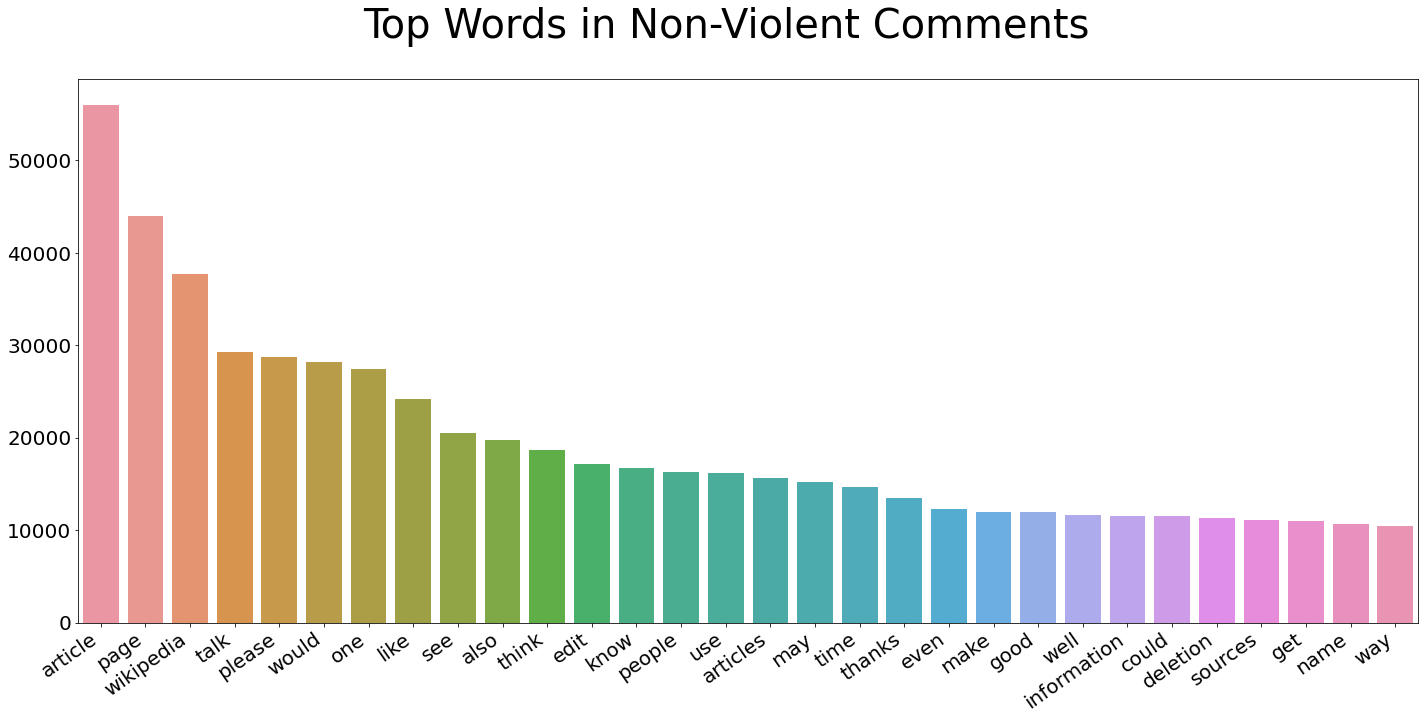

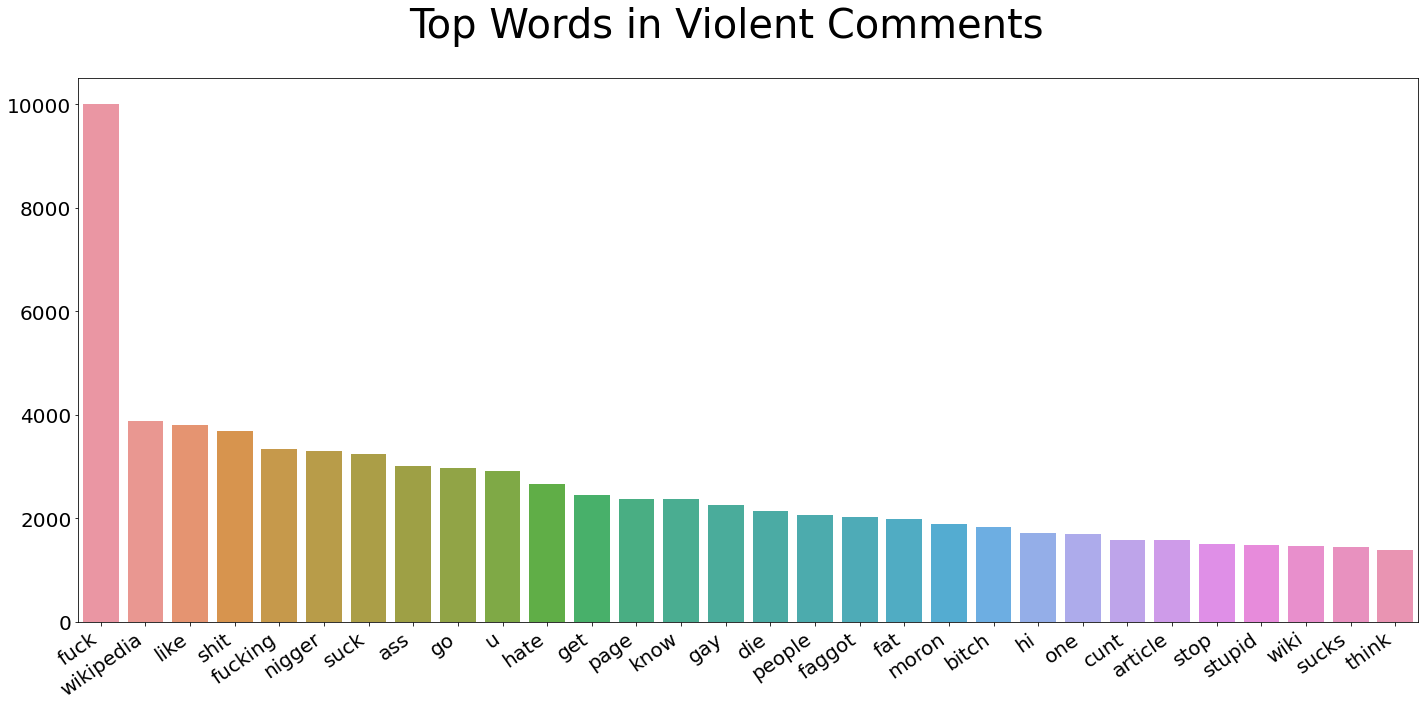

In [ ]:
def count_frequency(tokenizer):
    word_freq = [(k, v) for k, v in zip(tokenizer.word_counts.keys(), 
                                       tokenizer.word_counts.values())]
    word_freq.sort(key = lambda tup: tup[1], reverse=True)
    stop_words = set(stopwords.words('english'))
    word_freq = [tup for tup in word_freq if tup[0] not in stop_words]
    return word_freq

def top_words_chart(word_freq, num_words, title):
    plt.figure(title, figsize = (24, 10))
    plt.suptitle(title, fontsize = 40)
    sns.barplot(x = [tup[0] for tup in word_freq[0:num_words]], 
                y = [tup[1] for tup in word_freq[0:num_words]])
    plt.yticks(fontsize = 20)
    plt.xticks(fontsize = 20, rotation = 35, ha = 'right')
    plt.show()

nonviol_tokenizer = Tokenizer(filters = string.punctuation + '\n', lower=True)
nonviol_tokenizer.fit_on_texts(train.comment_text_transf[train.violent == 0])
top_words_chart(count_frequency(nonviol_tokenizer), 30, 'Top Words in Non-Violent Comments')

viol_tokenizer = Tokenizer(filters = string.punctuation + '\n', lower=True)
viol_tokenizer.fit_on_texts(train.comment_text_transf[train.violent == 1])
top_words_chart(count_frequency(viol_tokenizer), 30, 'Top Words in Violent Comments')

In [ ]:
train.to_csv('../../data/transformed/final/train_addFeatures.csv', index=False)
test.to_csv('../../data/transformed/final/test_addFeatures.csv', index=False)

In [ ]:
train.drop(['comment_text', 
            'length', 
            'caps',
            'exclamation',
            'qmark',
            'sequence_comment',
            ], axis=1).to_csv('../../data/transformed/final/train.csv', index=False)
test.drop(['comment_text', 
           'length', 
           'caps',
           'exclamation',
           'qmark',
           'sequence_comment',
           ], axis=1).to_csv('../../data/transformed/final/test.csv', index=False)

In [ ]:
train_censor.to_csv('transformed_censor_profanity/train_profanity_censor.csv', index=False)
test_censor.to_csv('transformed_censor_profanity/test_profanity_censor.csv', index=False)

KeyboardInterrupt: ignored

In [ ]:
test

NameError: ignored

In [ ]:
train_censor = pd.read_csv('transformed_censor_profanity/train_profanity_censor.csv')
test_censor = pd.read_csv('transformed_censor_profanity/test_profanity_censor.csv')

FileNotFoundError: ignored

In [ ]:
train_censor.head()

,comment_text,violent
0,********** BEFORE YOU **** AROUND ON MY WORK,1
1,"Hey what is it. talk . What is it an exclusive group of some WP TALIBANS who are good at destroying, self appointed purist who GANG UP any one who asks them questions abt their ANTI SOCIAL and DESTRUCTIVE non contribution at WP? Ask Sityush to clean up his behavior than issue me nonsensical warnings",1
2,"Bye! Don't look, come or think of comming back! Tosser.",1
3,"You are *** or antisemmitian? Archangel WHite Tiger Meow! Greetingshhh! Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not ****/Gypsys/Slavs/anyone 1 If you are anti semitian, than shave your head bald and go to the skinhead meetings! 2 If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your *** pals! 3 First and last warning, you ******* *** I won't appreciate if any more **** shwain would write in my page! I don't wish to talk to you anymore! Beware of the Dark Side!",1
4,"**** YOUR FILTHY MOTHER IN THE ***, DRY!",1


In [ ]:
import pandas as pd
import numpy as np
import re

drive.mount('/drive') 
%cd "../../drive/MyDrive/W266 Project/data"
train_censor = pd.read_csv('transformed_censor_profanity/train_profanity_censor.csv')
test_censor = pd.read_csv('transformed_censor_profanity/test_profanity_censor.csv')
re_compile = re.compile('[\*]{2,}')
def check_double_quotes(x):
  if re_compile.match(x):
    print(x)
  else:
    print("nomatch")

In [ ]:
re_compile = re.compile('[\*]{2,}')
def check_double_quotes(x):
  if re_compile.match(x):
    print(x)
  else:
    print("nomatch")

NameError: ignored

In [ ]:
check_double_quotes('I am here "aditya" ')

NameError: ignored